This file contains some basic work we did parsing files. We have two main options, which we show for completeness, although the figures in the second method were used in the end. We experimented with some minhashing as well. 

In [12]:
import gpxpy
import xml.etree.ElementTree as ET
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

This cell is our initial experiments, where we made some plots to help us understand the data. There is a bit of cleaning as well

In [13]:
def parse_gpx(file_path):
    with open(file_path, 'r') as f:
        gpx = gpxpy.parse(f)

    #all the vars we will use
    lats = []
    longs = []
    elevations = []
    times = []
    hrs = []
    cadences = []
    powers = []
    
    for track in gpx.tracks:
        for segment in track.segments:
            print(f"Track Name: {track.name}") #print for progress check
            print(f"Track Type: {track.type}")

            for point in segment.points:
                lats.append(point.latitude)
                longs.append(point.longitude)
                elevations.append(point.elevation)
                times.append(point.time)
                
                heart_rate = None
                cadence = None
                if point.extensions: #some of the niche points are stored in a weird way, so we have to extract differently
                    for ext in point.extensions:
                        
                        ext_xml = ET.ElementTree(ext)
                        hr_elem = ext_xml.find('.//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr')
                        cad_elem = ext_xml.find('.//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}cad')
                        pow_elem = ext_xml.find('power')
                        #hr and cadence if found
                        if hr_elem is not None:
                            hrs.append(hr_elem.text)
                        if cad_elem is not None:
                            cadences.append(cad_elem.text)
                        if ext.tag == 'power':
                            powers.append(ext.text)
    return lats, longs, elevations, times, hrs, cadences, powers


Track Name: Lunch Run
Track Type: running
Track Name: Afternoon Run
Track Type: running


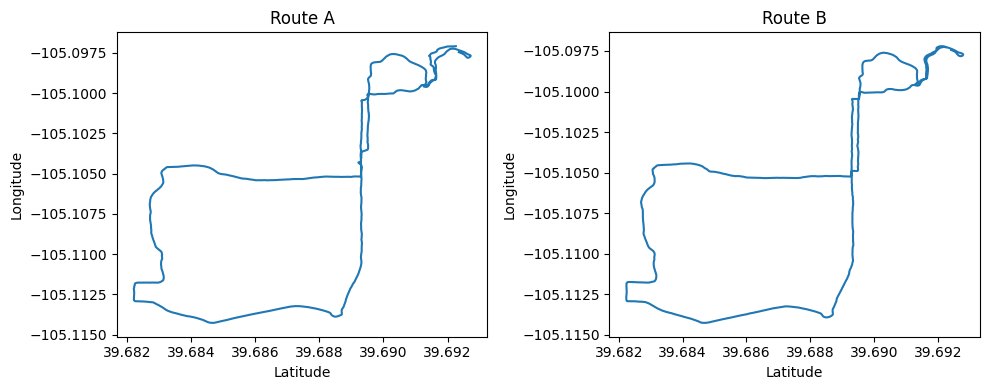

In [14]:
#Creating visual for minhashing demo later
file_path = 'Data/04052025_run.gpx'
lats, longs, elevations, times, hrs, cadences, powers = parse_gpx(file_path)
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(lats, longs)
ax[0].set_title("Route A")
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Longitude")

file_path = 'Data/04062025_run.gpx'
lats, longs, elevations, times, hrs, cadences, powers = parse_gpx(file_path)

ax[1].plot(lats, longs)
ax[1].set_title("Route B")
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Longitude")

plt.tight_layout()

Track Name: Afternoon Run
Track Type: running
0.1020840936543291


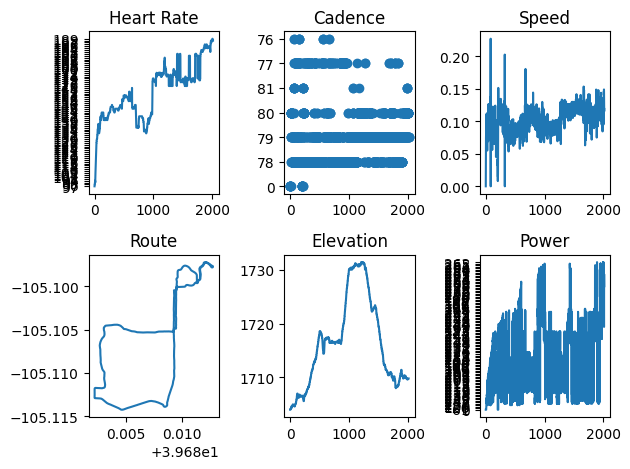

In [16]:
#plotting some data to help understand it better later
file_path = 'Data/04062025_run.gpx'
lats1, longs1, elevations1, times1, hrs1, cadences1, powers1 = parse_gpx(file_path)

#To get velocity, take change between times (this is 1/sec) of pos data)
vels = []
x_old, y_old = lats1[0], longs1[0]
# print(lats1, longs1)
for i, x in enumerate(lats1):
    y = longs1[i]
    dist = np.sqrt((x_old - x)**2 + (y_old - y)**2)
    vels.append(dist)
    x_old = x
    y_old = y

vels = np.array(vels)
# current units are degrees/sec
vels *= 3600 #convert to degrees/hr
print(np.mean(vels))

fig, ax = plt.subplots(2,3)
xs = [i for i in range(len(hrs1))]
ax[0,0].plot([i for i in range(len(hrs1))], np.array(hrs1))
ax[0,0].set_title("Heart Rate")
ax[0,1].scatter(xs, cadences1)
ax[0,1].set_title("Cadence")
ax[1,0].plot(lats1, longs1)
ax[1,0].set_title("Route")
ax[1,1].plot(xs, elevations1)
ax[1,1].set_title("Elevation")
ax[0,2].plot(xs, vels)
ax[0,2].set_title("Speed")
ax[1,2].plot(xs, powers1)
ax[1,2].set_title("Power")
plt.tight_layout()



In [17]:
#some example data cleaning that we went through. This was a bit of the testing

#need to find some good values to bin on
print(len(lats1))
print(np.min(np.array(lats1)))
print(np.max(np.array(lats1)))
# print(lats1[800:815])

#have 6 decimals to work with, could try binning on 5?
lats1, longs1 = np.around(lats1, decimals=5), np.around(longs1, decimals=5)
# print(lats1[800:815])

#create a zipped list of coordinates, which will be the items in our set
coords = set(zip(lats1, longs1))
# print(coords)

2017
39.682231
39.692792


Below is the parsing code in general, and some example data plots as well. It is an alternate visual to the one we included in the paper. Below, we include the code for our visual in our paper

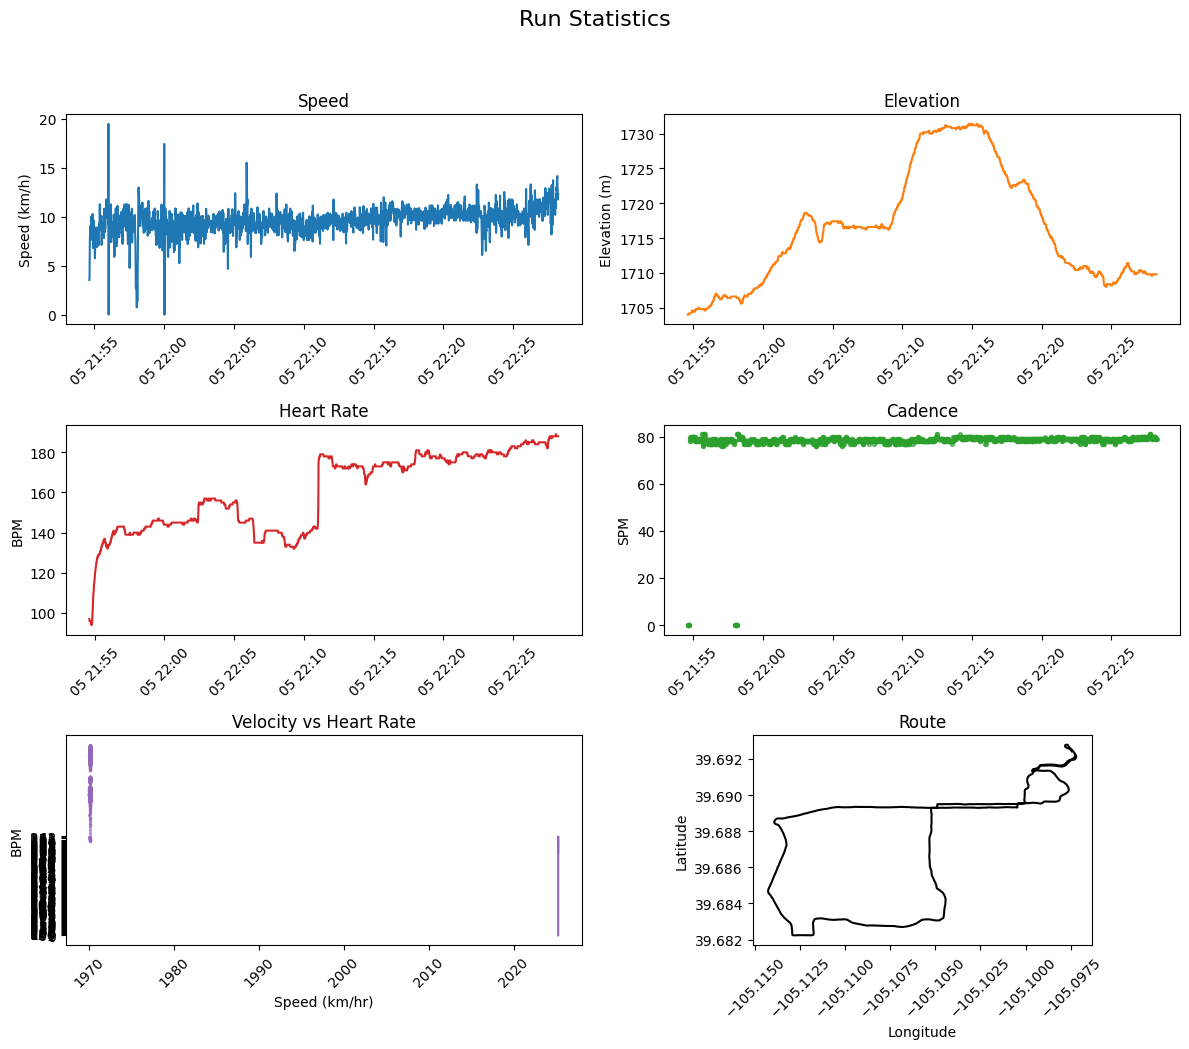

In [19]:
import gpxpy
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def parse_gpx(file_path):
    with open(file_path, 'r') as f:
        gpx = gpxpy.parse(f)

    lats, longs, elevations, times, hrs, cadences, powers = [], [], [], [], [], [], []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lats.append(point.latitude)
                longs.append(point.longitude)
                elevations.append(point.elevation)
                times.append(point.time)

                hr, cad, power = None, None, None
                for ext in point.extensions:
                    ext_xml = ET.ElementTree(ext)
                    hr_elem = ext_xml.find('.//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr')
                    cad_elem = ext_xml.find('.//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}cad')
                    # pow_elem = ext_xml.find('.//power')

                    if hr_elem is not None:
                        hrs.append(int(hr_elem.text))
                    if cad_elem is not None:
                        cadences.append(int(cad_elem.text))
                    if ext.tag == 'power':
                        powers.append(ext.text)
    times = [t.replace(tzinfo=None) for t in times]
    return lats, longs, elevations, times, hrs, cadences, powers

def compute_stats(lats, longs, elevations, times):
    from geopy.distance import geodesic
    speeds, dists = [], []
    total_dist = 0.0

    for i in range(1, len(lats)):
        pt1 = (lats[i-1], longs[i-1])
        pt2 = (lats[i], longs[i])
        dist = geodesic(pt1, pt2).meters
        time_diff = (times[i] - times[i-1]).total_seconds()

        speed = dist / time_diff if time_diff > 0 else 0
        speeds.append(speed)
        dists.append(dist)
        total_dist += dist

    elevation_gain = sum(np.diff(elevations)[np.diff(elevations) > 0])
    return speeds, dists, total_dist, elevation_gain

file_path = 'Data/04062025_run.gpx'
lats, longs, elevations, times, hrs, cadences, powers = parse_gpx(file_path)
speeds, dists, total_dist_m, elev_gain = compute_stats(lats, longs, elevations, times)
times_short = times[1:]  # because speeds are one shorter

fig, ax = plt.subplots(3, 2, figsize=(12, 11))
fig.suptitle("Run Statistics", fontsize=16)

# Speed
ax[0,0].plot(times_short, np.array(speeds) * 3.6, color='tab:blue')  # m/s to km/h
ax[0,0].set_title("Speed")
ax[0,0].set_ylabel("Speed (km/h)")

# Elevation
ax[0,1].plot(times, elevations, color='tab:orange')
ax[0,1].set_title("Elevation")
ax[0,1].set_ylabel("Elevation (m)")

# Heart Rate
if hrs:
    ax[1,0].plot(times[:len(hrs)], hrs, color='tab:red')
    ax[1,0].set_title("Heart Rate")
    ax[1,0].set_ylabel("BPM")

# Cadence
if cadences:
    ax[1,1].scatter(times[:len(cadences)], cadences, color='tab:green', alpha=.6, s=8)
    ax[1,1].set_title("Cadence")
    ax[1,1].set_ylabel("SPM")

# Power
if powers:
    ax[2,0].plot(times[:len(powers)], powers, color='tab:purple')
    ax[2,0].set_title("Power Output")
    ax[2,0].set_ylabel("Watts")

# Route Plot
ax[2,1].plot(longs, lats, color='black')
ax[2,1].set_title("Route")
ax[2,1].set_xlabel("Longitude")
ax[2,1].set_ylabel("Latitude")
ax[2,1].set_aspect('equal', adjustable='box')

#speed vs elevation
s = np.array(speeds) * 3.6
ax[2,0].scatter(s, hrs[:(len(s))], color = 'tab:purple', alpha=.6, s=2)
ax[2,0].set_title("Velocity vs Heart Rate")
ax[2,0].set_xlabel("Speed (km/hr)")
ax[2,0].set_ylabel("BPM")


for axis in ax.flat:
    axis.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


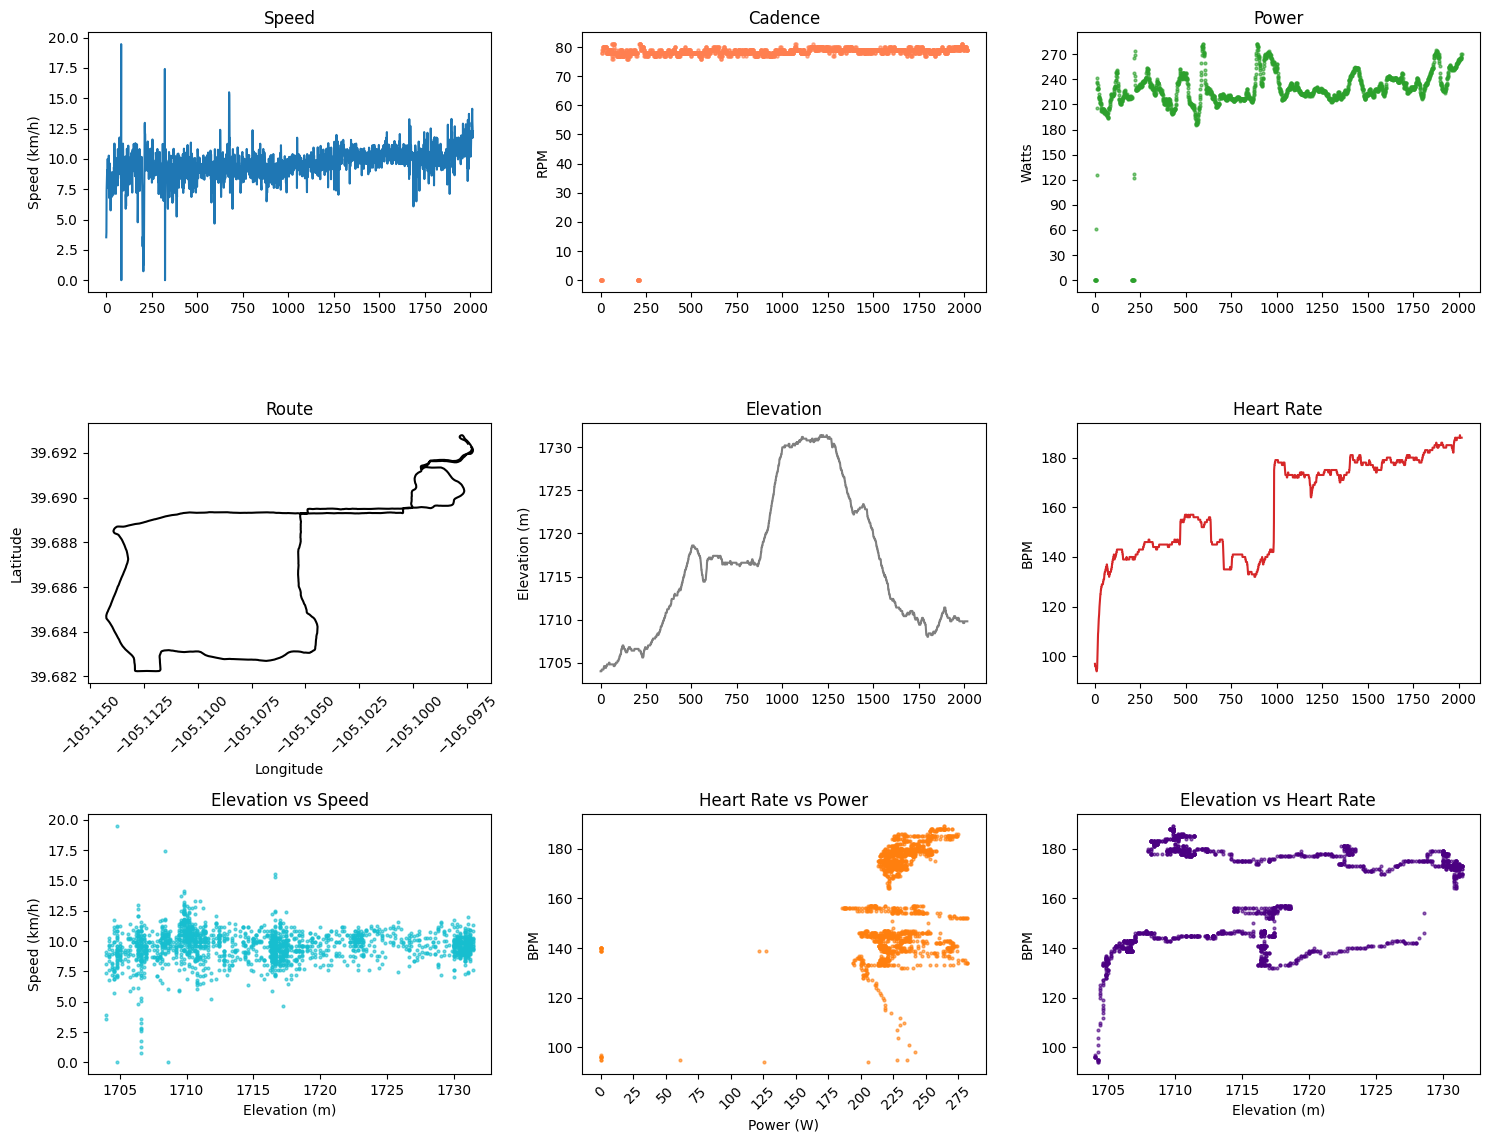

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

xs = np.linspace(0, len(hrs), len(hrs)) 

# Speed (converted to km/h)
ax[0, 0].plot(xs[:len(speeds)], np.array(speeds) * 3.6, color='tab:blue')  # m/s to km/h
ax[0, 0].set_title("Speed")
ax[0, 0].set_ylabel("Speed (km/h)")

# Cadence
ax[0, 1].scatter(xs[:len(cadences)], cadences, color='coral', s=5, alpha=0.6)
ax[0, 1].set_title("Cadence")
ax[0, 1].set_ylabel("RPM")

# Power
from matplotlib.ticker import MaxNLocator
powers = np.array(powers, dtype=np.float32)
xs_powers = np.linspace(0, len(powers), len(powers))
sorted_indices = np.argsort(xs_powers)
powers_sorted = powers[sorted_indices]
xs_sorted = xs_powers[sorted_indices]
ax[0, 2].scatter(xs_sorted, powers_sorted, color='tab:green', alpha=0.6, s=4)

# ax[0,2].scatter(xs[:len(powers)], powers, color='tab:green', alpha=0.6, s=4)
ax[0,2].set_title("Power")
ax[0,2].set_ylabel("Watts")
ax[0,2].yaxis.set_major_locator(MaxNLocator(nbins=12)) 

# Route (Lat vs Lon)
ax[1, 0].plot(longs, lats, color='black')
ax[1, 0].set_title("Route")
ax[1, 0].set_xlabel("Longitude")
ax[1, 0].set_ylabel("Latitude")
ax[1, 0].tick_params(axis='x', rotation=45)


# Elevation
ax[1, 1].plot(xs[:len(elevations)], elevations, color='tab:gray')
ax[1, 1].set_title("Elevation")
ax[1, 1].set_ylabel("Elevation (m)")

# Heart Rate
ax[1, 2].plot(xs[:len(hrs)], hrs, color='tab:red')
ax[1, 2].set_title("Heart Rate")
ax[1, 2].set_ylabel("BPM")

# Elevation vs Speed
ax[2, 0].scatter(elevations[:len(speeds)], np.array(speeds)[:len(elevations)] * 3.6,
                 color='tab:cyan', alpha=0.6, s=4)
ax[2, 0].set_title("Elevation vs Speed")
ax[2, 0].set_xlabel("Elevation (m)")
ax[2, 0].set_ylabel("Speed (km/h)")

# Heart Rate vs Power
hrs = np.array(hrs, dtype=np.float32)
powers = np.array(powers, dtype=np.float32)

min_len = min(len(hrs), len(powers))
hrs_sync = hrs[:min_len]
powers_sync = powers[:min_len]

sorted_indices = np.argsort(powers_sync)
powers_sorted = powers_sync[sorted_indices]
hrs_sorted = hrs_sync[sorted_indices]

ax[2, 1].scatter(powers_sorted, hrs_sorted, color='tab:orange', alpha=0.6, s=4)
ax[2, 1].set_title("Heart Rate vs Power")
ax[2, 1].set_xlabel("Power (W)")
ax[2, 1].set_ylabel("BPM")

ax[2,1].xaxis.set_major_locator(MaxNLocator(nbins=15))
ax[2, 1].tick_params(axis='x', rotation=45)


# Elevation vs Heart Rate 
ax[2, 2].scatter(elevations[:len(hrs)], hrs, color='indigo', alpha=0.6, s=4)
ax[2, 2].set_title("Elevation vs Heart Rate")
ax[2, 2].set_xlabel("Elevation (m)")
ax[2, 2].set_ylabel("BPM")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('data_showcase')